In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [14]:
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, 
                             confusion_matrix, classification_report, roc_curve, auc)

In [26]:
df = pd.read_csv('dataset.csv')
print(df.columns)
df.info()

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1

In [15]:
X = df.drop('target', axis=1)
y = df['target']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
numerical_cols = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
categorical_nominal_cols = ['chest pain type', 'resting ecg', 'ST slope']
binary_cols = ['sex', 'fasting blood sugar', 'exercise angina']


In [28]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_nominal_cols),
    ('binary', 'passthrough', binary_cols)
])

In [29]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42)
}

In [19]:
results= []


In [32]:
import warnings
warnings.filterwarnings("ignore")


for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = cv_scores
    
    # Full training and evaluation
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Print results
    print(f'\n{name} Performance:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))


Logistic Regression Performance:
Accuracy: 0.8613
Precision: 0.8550
Recall: 0.8889
F1 Score: 0.8716
ROC AUC: 0.9308

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       112
           1       0.85      0.89      0.87       126

    accuracy                           0.86       238
   macro avg       0.86      0.86      0.86       238
weighted avg       0.86      0.86      0.86       238


Random Forest Performance:
Accuracy: 0.9244
Precision: 0.9355
Recall: 0.9206
F1 Score: 0.9280
ROC AUC: 0.9739

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       112
           1       0.94      0.92      0.93       126

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238


SVM Performance:
Accuracy: 0.8782
Precision: 0.8760
Recall: 0.8968
F1

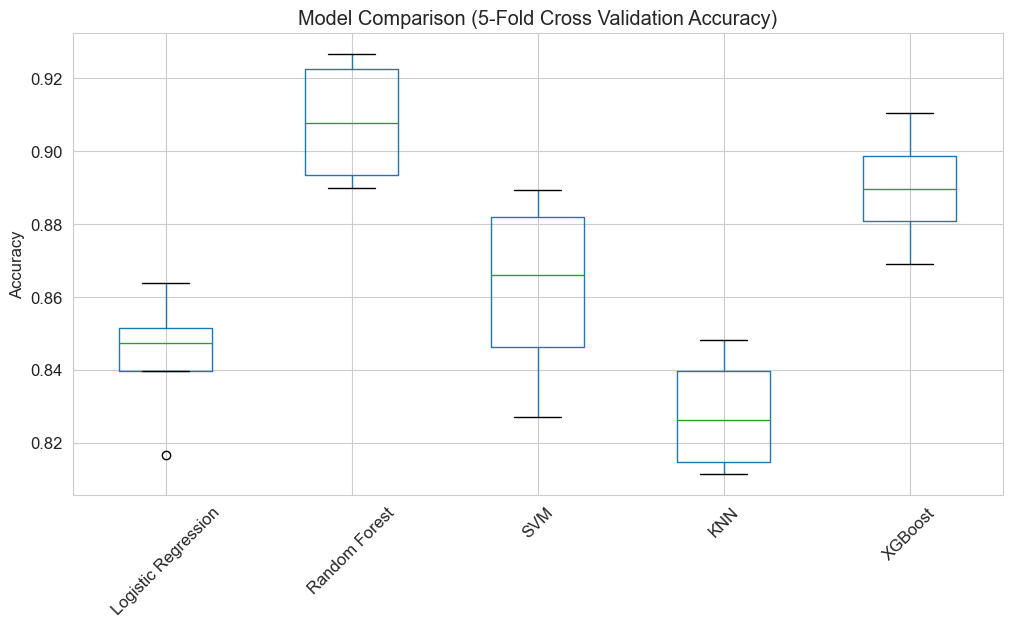

In [34]:
plt.figure(figsize=(12, 6))
pd.DataFrame(results).boxplot()
plt.title('Model Comparison (5-Fold Cross Validation Accuracy)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [36]:
#Model tuning- Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, 
                          scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(f'\nBest Parameters: {grid_search.best_params_}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.4f}')



Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Test Accuracy: 0.9244


Text(0, 0.5, 'Features')

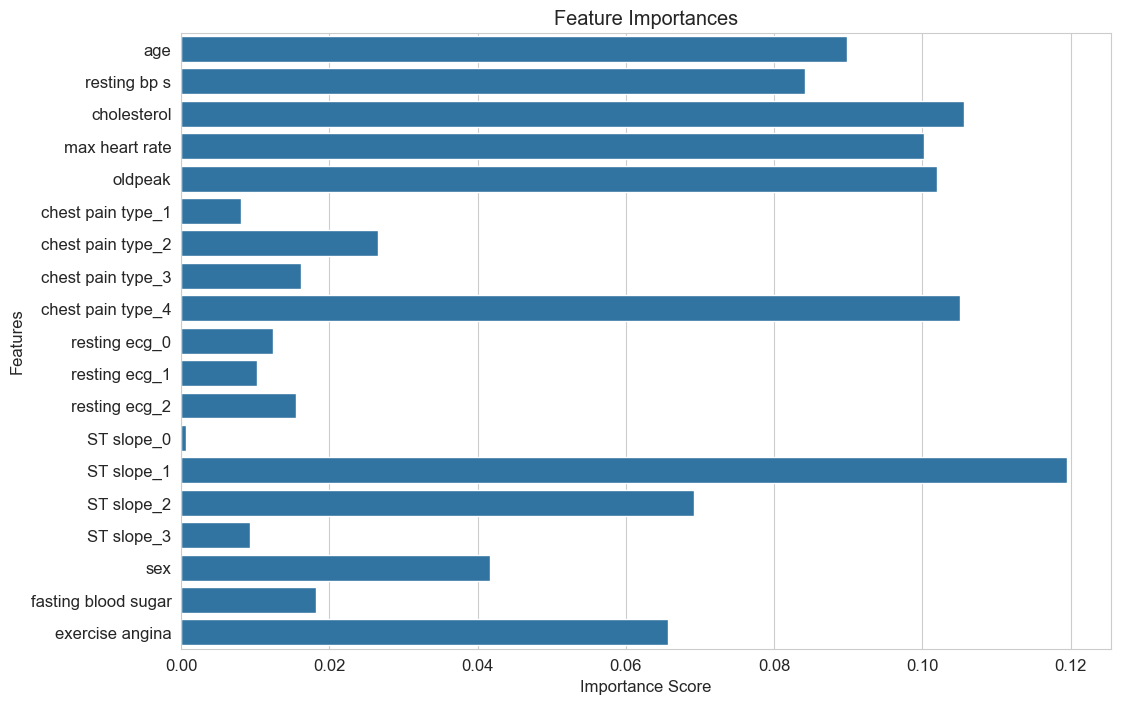

In [40]:
preprocessor.fit(X_train)
feature_names = numerical_cols.copy()
feature_names += list(preprocessor.named_transformers_['cat']\
                      .get_feature_names_out(categorical_nominal_cols))
feature_names += binary_cols

importances = best_model.named_steps['classifier'].feature_importances_

plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')